Cell 1 – Imports + Load Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data from baseline module
train = pd.read_csv("../baseline_prophet_forecast/data/train.csv")
features = pd.read_csv("../baseline_prophet_forecast/data/features.csv")
stores = pd.read_csv("../baseline_prophet_forecast/data/stores.csv")

# Merge to get a rich frame (you may not need all columns, but it's consistent)
df = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"])
    .merge(stores, on="Store")
)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Store", "Dept", "Date"])
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


Cell 2 – Build Time Series for a Store–Dept

In [16]:
store = 1
dept = 1

ts = (
    df[(df["Store"] == store) & (df["Dept"] == dept)]
    [["Date", "Weekly_Sales"]]
    .rename(columns={"Date": "ds", "Weekly_Sales": "y"})
    .sort_values("ds")
    .set_index("ds")
)

# Ensure weekly frequency
#ts = ts.asfreq("W")
ts.head()


,y
ds,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


Cell 3 – Approximate Forecast + Errors
We need a simple forecast baseline to approximate forecast errors.
Use a 4-week rolling mean:

In [17]:
ts["forecast"] = ts["y"].rolling(4).mean()
ts["error"] = ts["y"] - ts["forecast"]

ts = ts.dropna()
ts.head()


,y,forecast,error
ds,,,
2010-02-26,19403.54,32990.7700,-13587.2300
2010-03-05,21827.90,32216.6200,-10388.7200
2010-03-12,21043.39,25967.5950,-4924.2050
2010-03-19,22136.64,21102.8675,1033.7725
2010-03-26,26229.21,22809.2850,3419.9250


Forecast errors will proxy the uncertainty we’re designing safety stock against.

Cell 4 – Lead-Time Demand and Safety Stock

We assume:

Lead time = 2 weeks (you can parametrize)

Target service level = 95%

Safety stock formula:

SS=z⋅σLT
	​


where:

z = service level factor (95% → 1.65)

𝜎𝐿𝑇= std dev of demand during lead time or of forecast error during LT

Here, we’ll use demand during lead time as a proxy.

In [18]:
lead_time_weeks = 2
service_level = 0.95
z = norm.ppf(service_level)   # ≈1.645

# Demand during lead time (rolling sum over LT)
ts["lt_demand"] = ts["y"].rolling(lead_time_weeks).sum()
lt_demand = ts["lt_demand"].dropna()

mu_lt = lt_demand.mean()
sigma_lt = lt_demand.std()

safety_stock = z * sigma_lt

print(f"Mean lead-time demand: {mu_lt:.2f}")
print(f"Std dev lead-time demand: {sigma_lt:.2f}")
print(f"Safety stock for {service_level:.0%} service: {safety_stock:.2f} units")


Mean lead-time demand: 44366.16
Std dev lead-time demand: 17072.75
Safety stock for 95% service: 28082.17 units


Cell 5 – Stock-out Probability vs Inventory Level

We model lead-time demand as Normal(𝜇𝐿𝑇,𝜎𝐿𝑇) and compute:

𝑃(stockout)=𝑃(𝐷𝐿𝑇>𝐼)P(stockout)=P(DLT>I)

for different inventory levels 𝐼

In [22]:
# Define a range of inventory levels around the mean LT demand
inventory_levels = np.linspace(mu_lt * 0.5, mu_lt * 2.0, 50)

# Stock-out probability: 1 - CDF at inventory level
stockout_probs = 1 - norm.cdf(inventory_levels, loc=mu_lt, scale=sigma_lt)

# Put into a DataFrame
risk_table = pd.DataFrame({
    "inventory_level": inventory_levels,
    "stockout_probability": stockout_probs
})

risk_table.head()


,inventory_level,stockout_probability
0,22183.082482,0.903084
1,23541.230389,0.888725
2,24899.378296,0.872904
3,26257.526203,0.855581
4,27615.674110,0.836734


Save the table:

In [ ]:
risk_table.to_csv("../../artifacts/inventory_risk_table_store1_dept1.csv", index=False)

Cell 6 – Plot Stock-out Curve

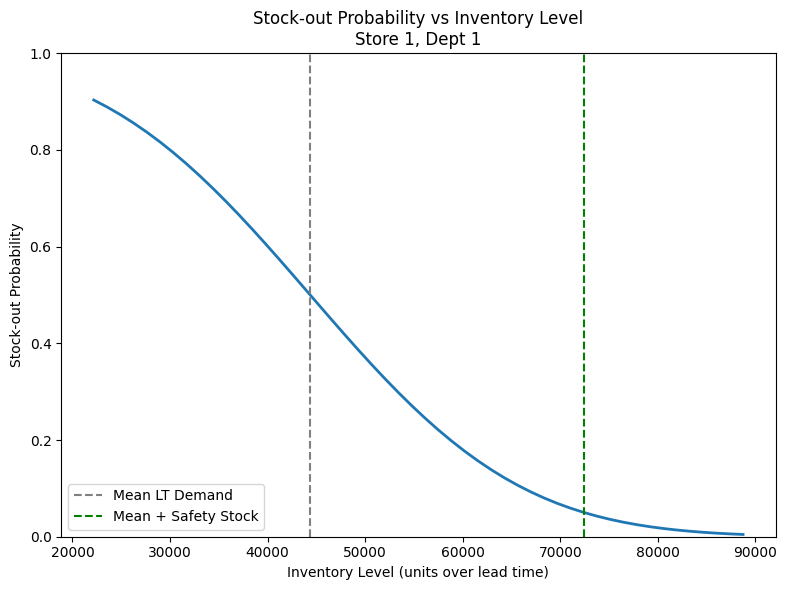

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(inventory_levels, stockout_probs, linewidth=2)
plt.axvline(mu_lt, color="grey", linestyle="--", label="Mean LT Demand")
plt.axvline(mu_lt + safety_stock, color="green", linestyle="--", label="Mean + Safety Stock")

plt.title(f"Stock-out Probability vs Inventory Level\nStore {store}, Dept {dept}")
plt.xlabel("Inventory Level (units over lead time)")
plt.ylabel("Stock-out Probability")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig("images/stockout_curve_store1_dept1.png")
plt.show()


Cell 7 – Markdown: Interpret Results

Interpretation
• Lead-time demand is summarized by a mean (μ) and uncertainty (σ).
• Safety stock is calculated as 𝑆𝑆=𝑧⋅𝜎𝐿𝑇
, where z corresponds to the target service level (e.g., 95%).
• The stock-out probability curve shows how risk decreases as inventory increases:
– Around μ, stock-out probability is ~50%.
– At μ + safety stock (for 95% SL), stock-out probability is ≈ 5%.
• In practice, this logic is applied across SKUs, sometimes with different lead times and service levels per segment (e.g., critical vs non-critical items).